In [87]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import Lasso, LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor

lss = [(0, (1, 10)), '--', '-.', (0, (1, 1)), (0, (3, 5, 1, 5, 1, 5)), (0, (3, 1, 1, 1, 1, 1))]
flag_ls = True

In [11]:
def sharpe(x):
    return x.mean() / x.std()

def bootstrap_dataset(data, id_vars, value_var, func, n=500):
    encluse_flag = (type(id_vars) != list) or (len(id_vars) == 1)
    if type(id_vars) != list:
        id_vars = [id_vars]
    bs_dfs = []
    for conf, group_df in data.groupby(id_vars):
        values = group_df[value_var].values
        values_size = values.size
        boot = [func(values[np.random.randint(values_size, size=values_size)]) for it in range(n)]
        if encluse_flag: 
            conf = [conf]
        data_dict = dict(zip(id_vars, conf))
        data_dict[value_var] = boot
        
        bs_dfs.append(pd.DataFrame(data_dict))
    return pd.concat(bs_dfs)

In [ ]:
# results_df = pd.read_pickle('data/results_sp500.pkl')
results_df = pd.read_pickle('data/results_sp500_2.pkl')
results_df['trading_strategy'] = results_df['trading_method'].str.split(' ', expand=True).iloc[:, -1].values
results_df = results_df[results_df['avg_month_returns'] != 0].drop(columns=['index',])
expected_return_benchmark = results_df[results_df['benchmark']]['avg_month_returns'].mean()
expected_return_benchmark = expected_return_benchmark / results_df[results_df['benchmark']]['avg_month_returns'].std()

In [ ]:
clean_results_df = results_df.drop(columns=['n_positions_avg', 'n_positions_compl', 'n_positions_pair'])
melted_results_df = clean_results_df.melt(clean_results_df.columns[3:])
melted_results_df = melted_results_df[melted_results_df['value'] != 0]

In [228]:
# melted_results_df_no_bench = melted_results_df[melted_results_df['benchmark'] == False].copy()
# spreads_method_config = melted_results_df_no_bench['spreads_method'].str.split(' ', expand=True).iloc[:, 1:]
# melted_results_df_no_bench['spreads_method_config'] = spreads_method_config[1] + ' ' + spreads_method_config[2]
# melted_results_df_no_bench[['trading_method_name', 'w', 'q', 'gamma', 'trading_strategy']] = melted_results_df_no_bench['trading_method'].str.split(' ', expand=True)
# melted_results_df_no_bench['gamma-q'] = melted_results_df_no_bench['gamma'] + ' - ' + melted_results_df_no_bench['q']
# melted_results_df_no_bench['w'] = melted_results_df_no_bench['w'].str.split('=', expand=True)[1].astype(int)
# melted_results_df_no_bench['corr-k'] = melted_results_df_no_bench['spreads_method'].str.split('-', expand=True)[1]
# melted_results_df_no_bench[['date', 'config', 'variable', 'value']].sample(15)

# Framework

I risultati qui presenti sono stati ottenuti usando il mio piccolo dataset contenente $\sim 430$ aziende contenute attualmente nell'SP500 dal 1995-02 al 2022-09. Il codice per eseguire la simulazione con i dati CSRP è il medesimo tuttavia essendo quel dataset sostanzialmente più grande e richiedendo molto più tempo ho pensato di eseguire una prima grid search su questo dataset piccolo al fine di selezionare un sottoinsieme dei parametri da testare.

Durante l'implementazione del motore per il backtesting ho identificato 3 fasi indipendenti l'una dall'altra, in ognuna delle quali diversi approcci erano perseguibili. Le tre fasi le ho denominate:

* data / residuals, in questa fase vengono scelti i dati da utilizzare nelle fasi successive per estrarre gli spreads, etc. gli approcci disponibili sono:
    1. returns, vengono utilizzati i log-returns mensili 
    2. residuals, vengono utilizzati i residui uscenti da una linear regression usando i Fama-French 5 factors (tramite cross validation ho verificato che è meglio utilizzare una elastic net con parametro $\alpha = \sim 3 \cdot 10^{-3}$ piuttosto che gli OLS)
* spreads, in questa fase vengono presi in input i dati uscenti dalla fase precedente e calcolati gli spreads, gli approcci che ho testato sono:
    1. Identity, in questo caso gli spreads sono esattamente i dati uscenti dalla fase precedente senza nessun processamento (questo approccio non è legato al pairs trading, rappresenta un benchmark)
    2. Corr-k, in questo caso i ritorni (residui) vengono approssimati con i ritorni (residui) delle k stocks più correlate in valore assoluto (i valori di k che ho testato sono 1, 5, 20, 50, essendo quelli che più ho ritrovato in letteratura)
    3. SGS, Smooth Graph Signal, questo algoritmo si basa sull'ipotesi che il segnale sul grafo sia smooth. Utilizzando un'approssimazione al posto del log det* l'algoritmo è estremamente veloce anche per grafi molto grandi [How to learn a graph from smooth signals, Vassilis Kalofolias, 2016]
    4. LGMRF, Laplacian constrained Gaussian Markov Random Field, questo algoritmo, dei miei test, sembra essere più "robusto" del precedente tuttavia è abbastanza lento, in quanto richiede il calcolo dei autovettori e autovalori molteplici volte, richiedendo all'incirca tra i 10s e i 20s per ogni esecuzione [Algorithms for Learning Graphs in Financial Markets, Cardoso et al., 2020]
* trading, in questa fase vengono creati i segnali che definiscono quali operazioni verranno effettuate nel prossimo periodo, per ogni stock viene aperta una operazione long (short) se 1. la media degli spreads degli ultimi $w$ periodi è all'interno del primo (ultimo) quantile $q$ e 2. la deviazione dello spread attuale dalla sua media negli ultimi $w$ periodi è minore (maggiore) di $\gamma$ volte la sua deviazione standard. In questo caso ho testato varie combinazioni di parametri:
    1. $w = 1, 2, 4, 12, 24$
    2. $q = 20\%, 50\%, 100\%$, quando $q = 1$ il filtro basato sui quantili viene ignorato
    3. $\gamma = 0, 2$, quando $\gamma = 0$ il filtro basato sulla deviazione standard viene ignorato
    4. Trading Strategy: long, short. 
    
Ho notato che i ritorni ottenuti comprando le stocks che l'algoritmo diceva di shortare si ottenevano ritorni positivi, sebbene più bassi del benchmark, pertanto da ora in avanti quando ci sarà scritto **trading_strategy='short'** mi riferirò ad i ritorni ottenuti con una posizione long quando l'algoritmo suggeriva una posizione short. Un possibile utilizzo, ipotizzo ben noto in letteratura, è quello di ridurre, in un portfolio, l'esposizione alle azioni che l'algoritmo ritiene siano sopravvalutate.

Il benchmark utilizzato è un equal weight portfolio su tutto il dataset.

Per verificare l'effetto che diversi metodi / hyper-parameter hanno sul risultato finale di seguito fisseremo di volta in volta una o più variabili e calcoleremo la distribuzione degli expected returns e dell'expected sharpe ratios tramite bootstrap. Dal momento che i risultati sono fortemente dipendenti dalla scelta della trading_strategy, per ogni combinazione mostreremo i risultati per trading_strategy='long' e per trading_strategy='short'.

Nel caso di trading_strategy='long' valori alti di ritorni attesi e di Sharpe ratio sono preferibili mentre nel caso di trading_strategy='short' valori bassi sono preferibili. 

**I grafici sono spesso accoppiati, quello superiore mostra gli expected returns, quello inferiore mostra gli expected Sharpe ratios**

# Data / Residuals

Di seguito mostriamo la differenza nei risultati quando vengono utilizzati i ritorni rispetto a quando vengono utilizzati i residui.

### Bootstrap Expected Returns

In [198]:
bs_expected_returns_residuals_method = bootstrap_dataset(
    melted_results_df_no_bench[((melted_results_df_no_bench['variable'] == 'avg_month_returns') &
                                (melted_results_df_no_bench['trading_strategy'] != 'both')
                               )], 
    id_vars=['trading_strategy', 'residuals_method'], 
    value_var='value', func=np.mean, n=5000)

bs_expected_sharpe_residuals_method = bootstrap_dataset(
    melted_results_df_no_bench[((melted_results_df_no_bench['variable'] == 'avg_month_returns') &
                                (melted_results_df_no_bench['trading_strategy'] != 'both')
                               )], 
    id_vars=['trading_strategy', 'residuals_method'], 
    value_var='value', func=sharpe, n=5000)

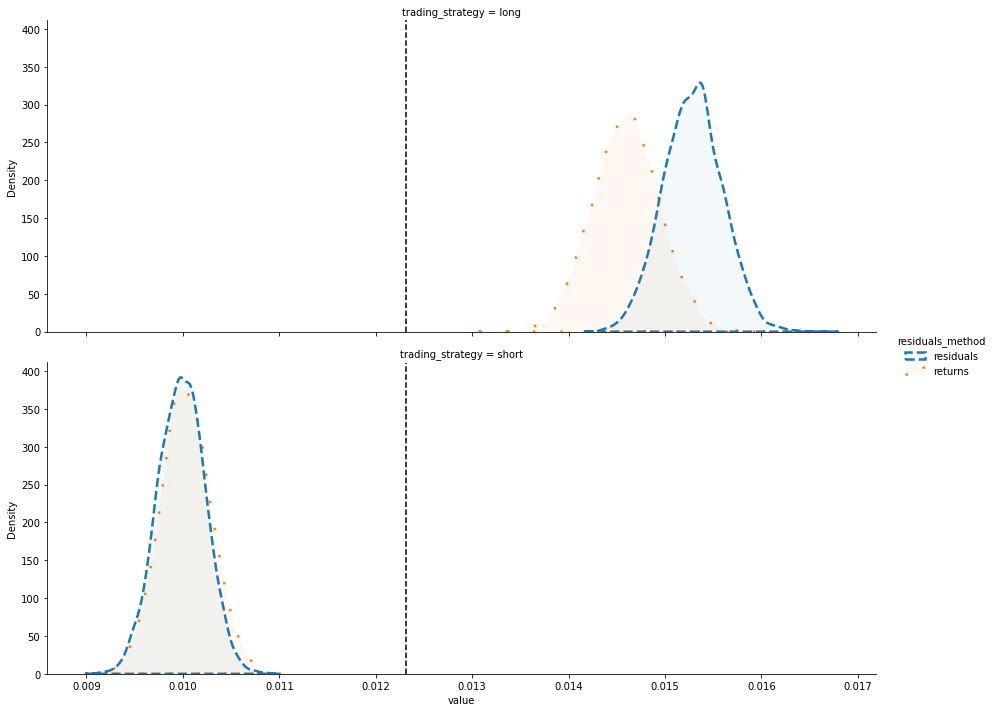

In [205]:
g = sns.displot(data=bs_expected_returns_residuals_method, x='value', kind='kde', fill=True, alpha=.05,
            hue='residuals_method', row='trading_strategy', aspect=2.5, linewidth=2.5)
    
if flag_ls:
    for ax in g.axes.flat:
        for line, ls in zip(ax.collections, lss):
            line.set_linestyle(ls)
        ax.axvline(expected_return_benchmark, ls='--', color='black')

    handles = g._legend.legendHandles[::-1]
    for handle, ls in zip(handles, lss):
        handle.set_ls(ls)
else:
    for ax in g.axes.flat:
        ax.axvline(expected_return_benchmark, ls='--', color='black')
    
plt.show()

In [212]:
# print('Long Returns:')
# display(bs_expected_returns_residuals_method[bs_expected_returns_residuals_method['trading_strategy'] == 'long'].groupby('residuals_method')['value'].describe().iloc[:, 1:].style.highlight_max())
# 
# print('\nShort Returns:')
# display(bs_expected_returns_residuals_method[bs_expected_returns_residuals_method['trading_strategy'] == 'short'].groupby('residuals_method')['value'].describe().iloc[:, 1:].style.highlight_min())

In [211]:
print('Long Returns:')
display(bs_expected_returns_residuals_method[bs_expected_returns_residuals_method['trading_strategy'] == 'long'].groupby('residuals_method')['value'].describe().iloc[:, 1:])

print('\nShort Returns:')
display(bs_expected_returns_residuals_method[bs_expected_returns_residuals_method['trading_strategy'] == 'short'].groupby('residuals_method')['value'].describe().iloc[:, 1:])

Long Returns:


,mean,std,min,25%,50%,75%,max
residuals_method,,,,,,,
residuals,0.015290,0.000306,0.014324,0.015081,0.015291,0.015491,0.016627
returns,0.014595,0.000346,0.013249,0.014360,0.014599,0.014827,0.015931



Short Returns:


,mean,std,min,25%,50%,75%,max
residuals_method,,,,,,,
residuals,0.009984,0.000245,0.009118,0.009815,0.009986,0.010151,0.010871
returns,0.010030,0.000261,0.009142,0.009859,0.010024,0.010205,0.010976


### Bootstrap Sharpe Ratio

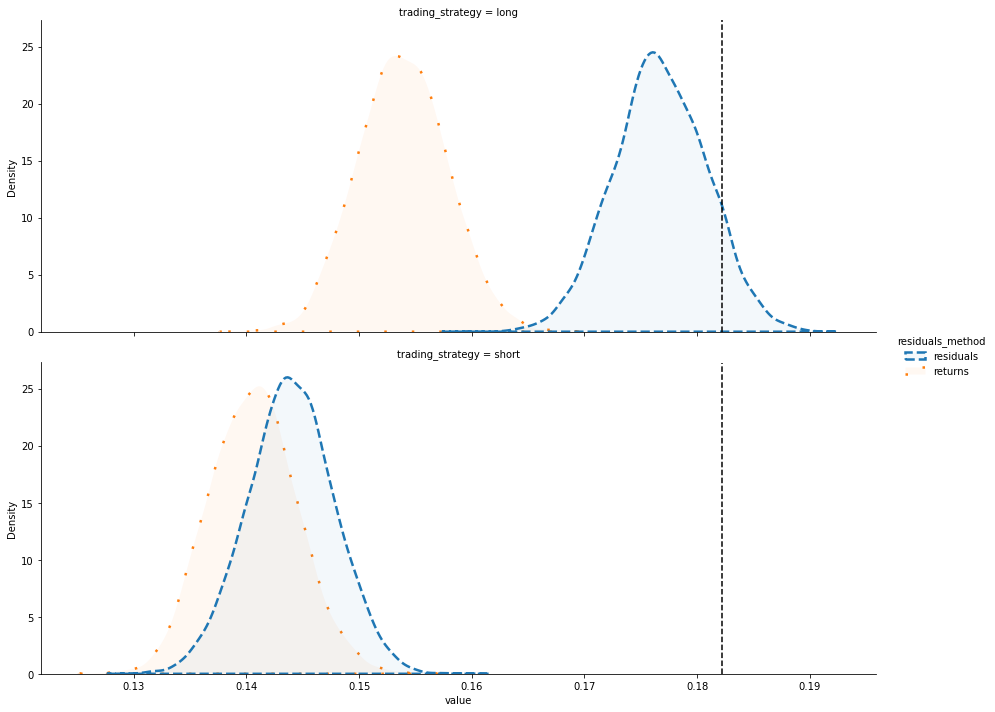

In [202]:
g = sns.displot(data=bs_expected_sharpe_residuals_method, x='value', kind='kde', fill=True, alpha=.05,
            hue='residuals_method', row='trading_strategy', aspect=2.5, linewidth=2.5)
    
if flag_ls:
    for ax in g.axes.flat:
        for line, ls in zip(ax.collections, lss):
            line.set_linestyle(ls)
        ax.axvline(expected_sharpe_benchmark, ls='--', color='black')

    handles = g._legend.legendHandles[::-1]
    for handle, ls in zip(handles, lss):
        handle.set_ls(ls)
else:
    for ax in g.axes.flat:
        ax.axvline(expected_sharpe_benchmark, ls='--', color='black')
    
plt.show()

In [213]:
# print('Long Sharpe:')
# display(bs_expected_sharpe_residuals_method[bs_expected_sharpe_residuals_method['trading_strategy'] == 'long'].groupby('residuals_method')['value'].describe().iloc[:, 1:].style.highlight_max())
# 
# print('\nShort Sharpe:')
# display(bs_expected_sharpe_residuals_method[bs_expected_sharpe_residuals_method['trading_strategy'] == 'short'].groupby('residuals_method')['value'].describe().iloc[:, 1:].style.highlight_min())

print('Long Sharpe:')
display(bs_expected_sharpe_residuals_method[bs_expected_sharpe_residuals_method['trading_strategy'] == 'long'].groupby('residuals_method')['value'].describe().iloc[:, 1:])

print('\nShort Sharpe:')
display(bs_expected_sharpe_residuals_method[bs_expected_sharpe_residuals_method['trading_strategy'] == 'short'].groupby('residuals_method')['value'].describe().iloc[:, 1:])

Long Sharpe:


,mean,std,min,25%,50%,75%,max
residuals_method,,,,,,,
residuals,0.176729,0.004098,0.159582,0.174054,0.176664,0.179546,0.190242
returns,0.153880,0.003956,0.139755,0.151194,0.153836,0.156564,0.168401



Short Sharpe:


,mean,std,min,25%,50%,75%,max
residuals_method,,,,,,,
residuals,0.143942,0.003833,0.129703,0.141412,0.143944,0.146462,0.159512
returns,0.140622,0.003872,0.127248,0.137874,0.140610,0.143176,0.155992


Come è possibile vedere l'utilizzo dei residui, in particolare in caso di strategia long, porta un grande beneficio sia in termini di ritorno medio che di Sharpe ratio.

# Spreads

In questa sezione verifichiamo se vi siano delle differenze nei risultati utilizzando diversi metodi nella fase di creazione degli spreads

## Corr-k

Questo metodo richiede la selezione di un hyper-paramer k che descrive il numero di stocks più correlate da utilizzare.

In [132]:
bs_expected_returns_corr = bootstrap_dataset(
    melted_results_df_no_bench[((~melted_results_df_no_bench['corr-k'].isna()) &
                                (melted_results_df_no_bench['variable'] == 'avg_month_returns') &
                                (melted_results_df_no_bench['trading_strategy'] != 'both')
                               )], 
    id_vars=['trading_strategy', 'corr-k', 'spreads_method_name'], 
    value_var='value', func=np.mean, n=5000)
bs_expected_returns_corr['corr-k'] = bs_expected_returns_corr['corr-k'].astype(int)

bs_expected_sharpe_corr = bootstrap_dataset(
    melted_results_df_no_bench[((~melted_results_df_no_bench['corr-k'].isna()) &
                                (melted_results_df_no_bench['variable'] == 'avg_month_returns') &
                                (melted_results_df_no_bench['trading_strategy'] != 'both')
                               )], 
    id_vars=['trading_strategy', 'corr-k', 'spreads_method_name'], 
    value_var='value', func=sharpe, n=5000)
bs_expected_sharpe_corr['corr-k'] = bs_expected_returns_corr['corr-k'].astype(int)

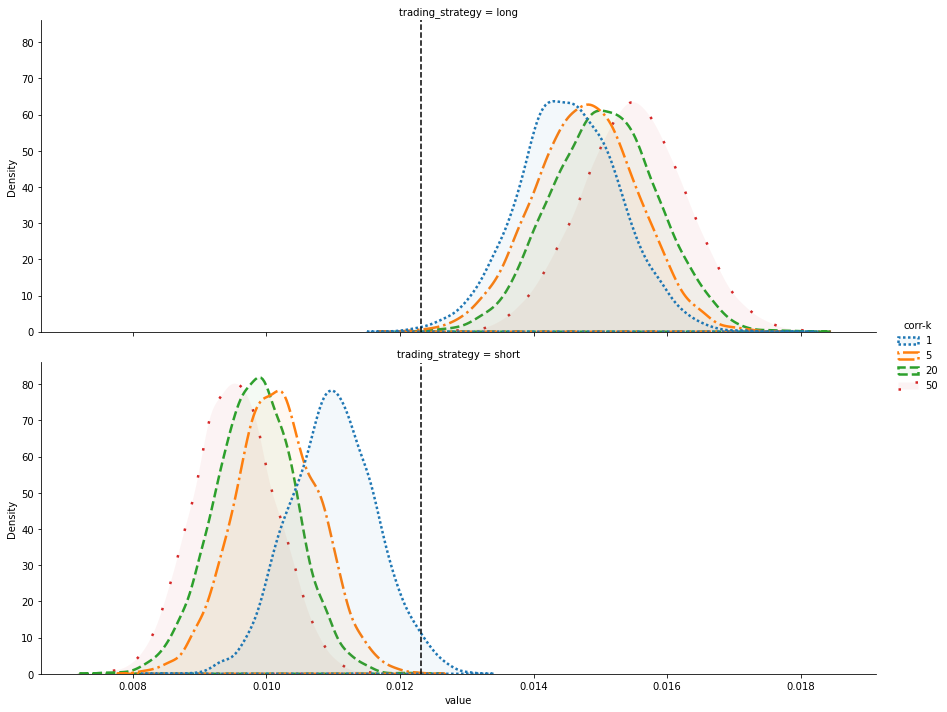

In [218]:
g = sns.displot(data=bs_expected_returns_corr, x='value', kind='kde', fill=True, alpha=.05,
            hue='corr-k', row='trading_strategy', aspect=2.5, linewidth=2.5, palette='tab10')
    
if flag_ls:
    for ax in g.axes.flat:
        for line, ls in zip(ax.collections, lss):
            line.set_linestyle(ls)
        ax.axvline(expected_return_benchmark, ls='--', color='black')

    handles = g._legend.legendHandles[::-1]
    for handle, ls in zip(handles, lss):
        handle.set_ls(ls)
else:
    for ax in g.axes.flat:
        ax.axvline(expected_return_benchmark, ls='--', color='black')
    
plt.show()

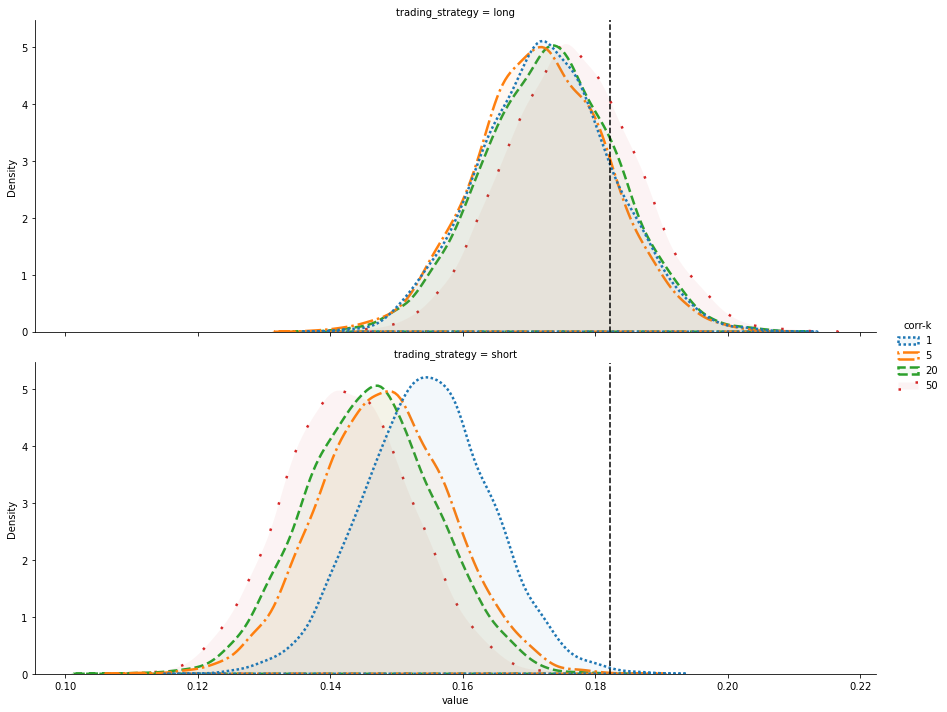

In [219]:
g = sns.displot(data=bs_expected_sharpe_corr, x='value', kind='kde', fill=True, alpha=.05,
            hue='corr-k', row='trading_strategy', aspect=2.5, linewidth=2.5, palette='tab10')
    
if flag_ls:
    for ax in g.axes.flat:
        for line, ls in zip(ax.collections, lss):
            line.set_linestyle(ls)
        ax.axvline(expected_sharpe_benchmark, ls='--', color='black')

    handles = g._legend.legendHandles[::-1]
    for handle, ls in zip(handles, lss):
        handle.set_ls(ls)
else:
    for ax in g.axes.flat:
        ax.axvline(expected_sharpe_benchmark, ls='--', color='black')
    
plt.show()

Come è possibile vedere dai grafici l'aumento del numero di stocks sembra portare un beneficio, quantomeno in termini di ritorno atteso. Aumentando il valore di k le distribuzioni tendono a spostarsi verso destra nel caso di strategia long e verso sigistra nel caso di strategia short. Questi movimenti non sono apprezzabili per quanto riguarda lo Sharpe ratio nel caso di strategia long.

### Graph Estimation Hyper-parameters (SGS, LGMRF)

Per questi due approcci basati sulla creazione di una laplaciana ho testato 4 possibili settaggi dipendenti dal valore di 2 variabili booleane:

* laplacian_root: se True veniva utilizzata la radice della laplaciana per calcoare i residui, in caso negativa veniva utilizzata direttamente la laplaciana;
* adjust_laplacian: guardando gli spreads ho notato una fortissima correlazione tra spreads e returns/residuals, per diminuire la correlazione tra questi ho pensato di fittare un OLS usando i returns/residuals approssimati dal grafo come variabile indipendente e i returns/residuals originali come variabile dipendente. Tutto ciò in ultima istanza comporta una variazione della diagonale dalla laplaciana. Se adjust_laplacian=True la diagonale della laplacaiana viene alterata come descritto altrimenti rimane invariata.

In [ ]:
bs_expected_returns_graph = bootstrap_dataset(
    melted_results_df_no_bench[((melted_results_df_no_bench['spreads_method_name'].isin(['SGS', 'LGMRF'])) &
                                (melted_results_df_no_bench['variable'] == 'avg_month_returns') &
                                (melted_results_df_no_bench['trading_strategy'] != 'both')
                               )], 
    id_vars=['trading_strategy', 'spreads_method_config', 'spreads_method_name'], 
    value_var='value', func=np.mean, n=5000)

bs_expected_sharpe_graph = bootstrap_dataset(
    melted_results_df_no_bench[((melted_results_df_no_bench['spreads_method_name'].isin(['SGS', 'LGMRF'])) &
                                (melted_results_df_no_bench['variable'] == 'avg_month_returns') &
                                (melted_results_df_no_bench['trading_strategy'] != 'both')
                               )], 
    id_vars=['trading_strategy', 'spreads_method_config', 'spreads_method_name'], 
    value_var='value', func=sharpe, n=5000)

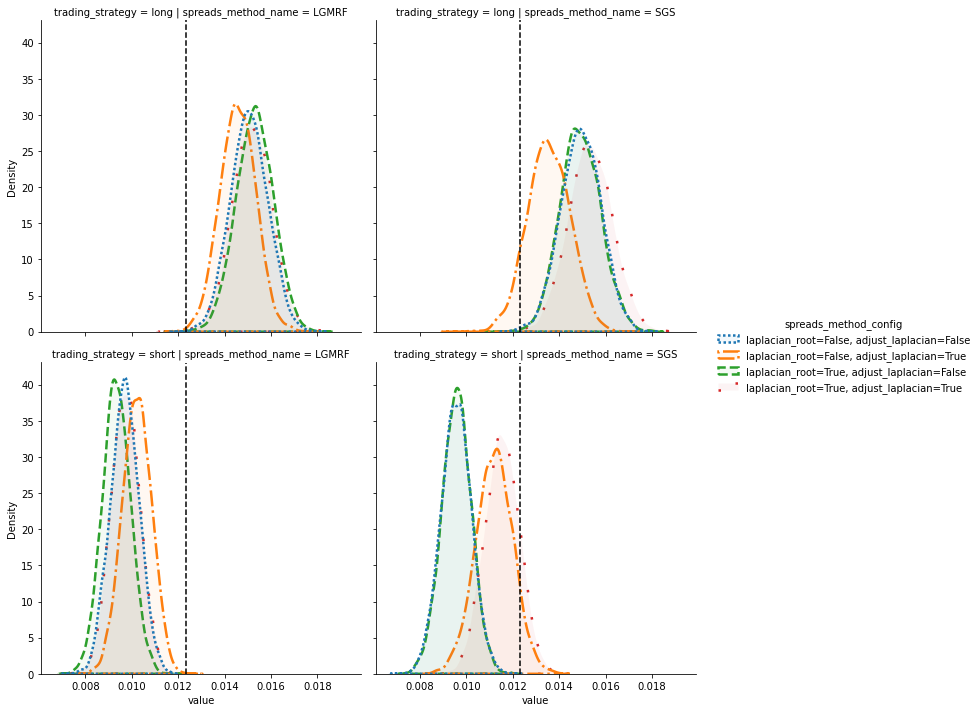

In [97]:
g = sns.displot(data=bs_expected_returns_graph, x='value', kind='kde', fill=True, alpha=.05,
            hue='spreads_method_config', row='trading_strategy', col='spreads_method_name', linewidth=2.5)
    
if flag_ls:
    for ax in g.axes.flat:
        for line, ls in zip(ax.collections, lss):
            line.set_linestyle(ls)
        ax.axvline(expected_return_benchmark, ls='--', color='black')

    handles = g._legend.legendHandles[::-1]
    for handle, ls in zip(handles, lss):
        handle.set_ls(ls)
else:
    for ax in g.axes.flat:
        ax.axvline(expected_return_benchmark, ls='--', color='black')
    
plt.show()

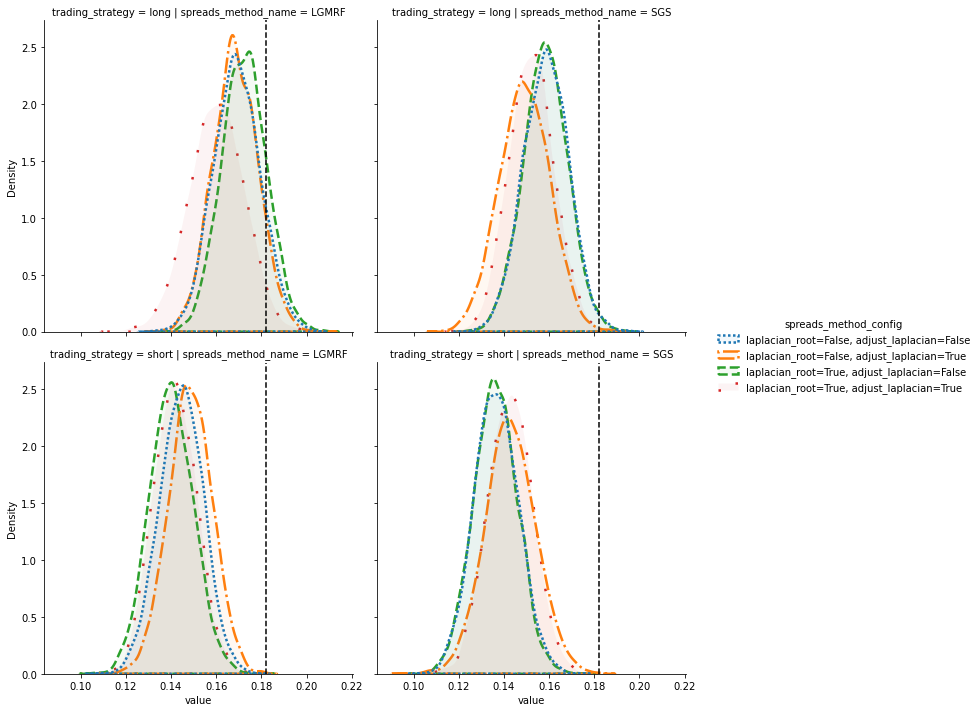

In [98]:
g = sns.displot(data=bs_expected_sharpe_graph, x='value', kind='kde', fill=True, alpha=.05,
            hue='spreads_method_config', row='trading_strategy', col='spreads_method_name', linewidth=2.5)
    
if flag_ls:
    for ax in g.axes.flat:
        for line, ls in zip(ax.collections, lss):
            line.set_linestyle(ls)
        ax.axvline(expected_sharpe_benchmark, ls='--', color='black')

    handles = g._legend.legendHandles[::-1]
    for handle, ls in zip(handles, lss):
        handle.set_ls(ls)
else:
    for ax in g.axes.flat:
        ax.axvline(expected_sharpe_benchmark, ls='--', color='black')
        
plt.show()

In generale non vi è molta differenza tra i vari approcci tuttavia le configurazioni in cui adjust_laplacian=True sembrano performare peggio di quelle in cui è False. 

La radice quadrata non sembra avere un grande effetto in termini di performance tuttavia in alcuni casi sembra aiutare leggermente, in particolare quando viene utilizzato LGMRF per l'inferenza del grafo ed una strategia short.

## Spreads Methods

Qui confrontiamo i vari metodi tra di loro. 

Come configurazione per il metodo basato sulle correlazioni ho selezionato *Corr-50*. Per quanto riguarda i metodi basati sui grafi ho selezionato quelli in cui *adjust_laplacian=False*. 

Per quanto riguarda i dati utilizzati qui ho scelto di selezionare solo i risultati basati sui redisui e non sui ritorni.

In [162]:
corr_50_filt = (melted_results_df_no_bench['corr-k'].isna() | (melted_results_df_no_bench['corr-k'] == '50'))
adjust_laplacian_false_filt = ((~melted_results_df_no_bench['spreads_method_name'].isin(['SGS', 'LGMRF'])) | 
                               melted_results_df_no_bench['spreads_method'].str.endswith('adjust_laplacian=False'))

In [186]:
bs_expected_returns_spread_method = bootstrap_dataset(
    melted_results_df_no_bench[(adjust_laplacian_false_filt &
                                corr_50_filt &
                                (melted_results_df_no_bench['variable'] == 'avg_month_returns') &
                                (melted_results_df_no_bench['trading_strategy'] != 'both') &
                                (melted_results_df_no_bench['residuals_method'] == 'residuals')
                               )], 
    id_vars=['trading_strategy', 'spreads_method_name'], 
    value_var='value', func=np.mean, n=5000)

bs_expected_sharpe_spread_method = bootstrap_dataset(
    melted_results_df_no_bench[(adjust_laplacian_false_filt &
                                corr_50_filt &
                                (melted_results_df_no_bench['variable'] == 'avg_month_returns') &
                                (melted_results_df_no_bench['trading_strategy'] != 'both') & 
                                (melted_results_df_no_bench['residuals_method'] == 'residuals')
                               )], 
    id_vars=['trading_strategy', 'spreads_method_name'], 
    value_var='value', func=sharpe, n=5000)

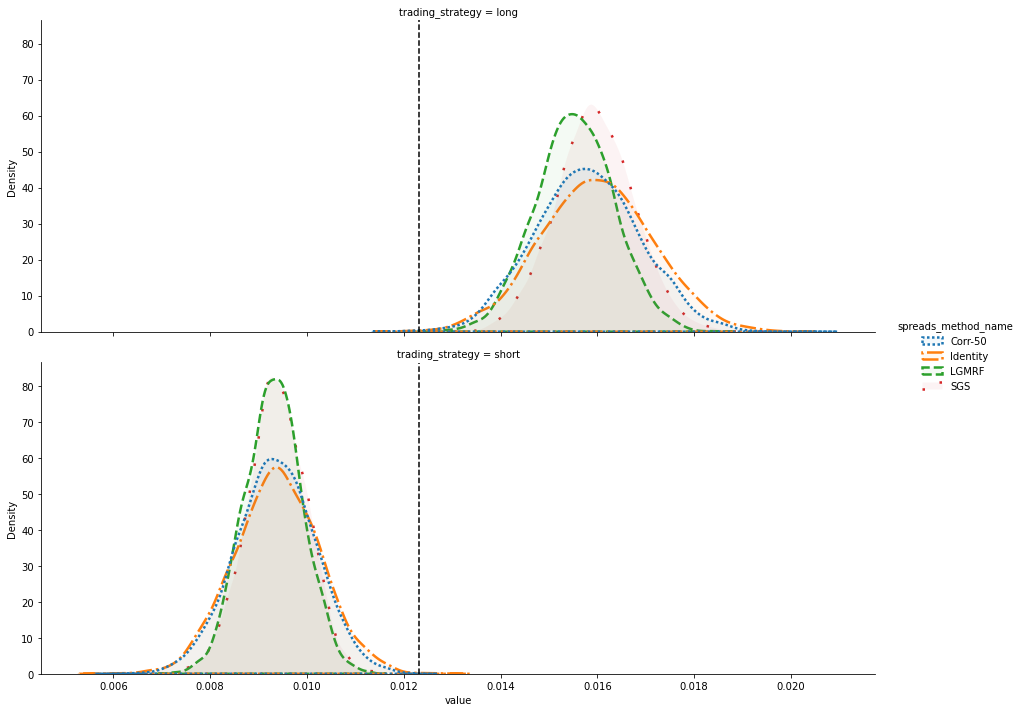

In [187]:
g = sns.displot(data=bs_expected_returns_spread_method, x='value', kind='kde', fill=True, alpha=.05,
            hue='spreads_method_name', row='trading_strategy', aspect=2.5, linewidth=2.5)
    
if flag_ls:
    for ax in g.axes.flat:
        for line, ls in zip(ax.collections, lss):
            line.set_linestyle(ls)
        ax.axvline(expected_return_benchmark, ls='--', color='black')

    handles = g._legend.legendHandles[::-1]
    for handle, ls in zip(handles, lss):
        handle.set_ls(ls)
else:
    for ax in g.axes.flat:
        ax.axvline(expected_return_benchmark, ls='--', color='black')
    
plt.show()

In [215]:
# print('Long Returns:')
# display(bs_expected_returns_spread_method[bs_expected_returns_spread_method['trading_strategy'] == 'long'].groupby('spreads_method_name')['value'].describe().iloc[:, 1:].style.highlight_max())
# 
# print('\nShort Returns:')
# display(bs_expected_returns_spread_method[bs_expected_returns_spread_method['trading_strategy'] == 'short'].groupby('spreads_method_name')['value'].describe().iloc[:, 1:].style.highlight_min())

print('Long Returns:')
display(bs_expected_returns_spread_method[bs_expected_returns_spread_method['trading_strategy'] == 'long'].groupby('spreads_method_name')['value'].describe().iloc[:, 1:])

print('\nShort Returns:')
display(bs_expected_returns_spread_method[bs_expected_returns_spread_method['trading_strategy'] == 'short'].groupby('spreads_method_name')['value'].describe().iloc[:, 1:])

Long Returns:


,mean,std,min,25%,50%,75%,max
spreads_method_name,,,,,,,
Corr-50,0.015793,0.001085,0.011952,0.015059,0.015781,0.016517,0.020371
Identity,0.015983,0.001157,0.012034,0.015201,0.015976,0.016763,0.019910
LGMRF,0.015536,0.000812,0.012513,0.015002,0.015540,0.016088,0.018408
SGS,0.015955,0.000808,0.012930,0.015412,0.015944,0.016493,0.019215



Short Returns:


,mean,std,min,25%,50%,75%,max
spreads_method_name,,,,,,,
Corr-50,0.009352,0.000828,0.006062,0.008810,0.009357,0.009904,0.012240
Identity,0.009382,0.000890,0.005771,0.008796,0.009381,0.009981,0.012879
LGMRF,0.009305,0.000604,0.007175,0.008903,0.009312,0.009706,0.011307
SGS,0.009379,0.000616,0.007110,0.008982,0.009377,0.009797,0.011572


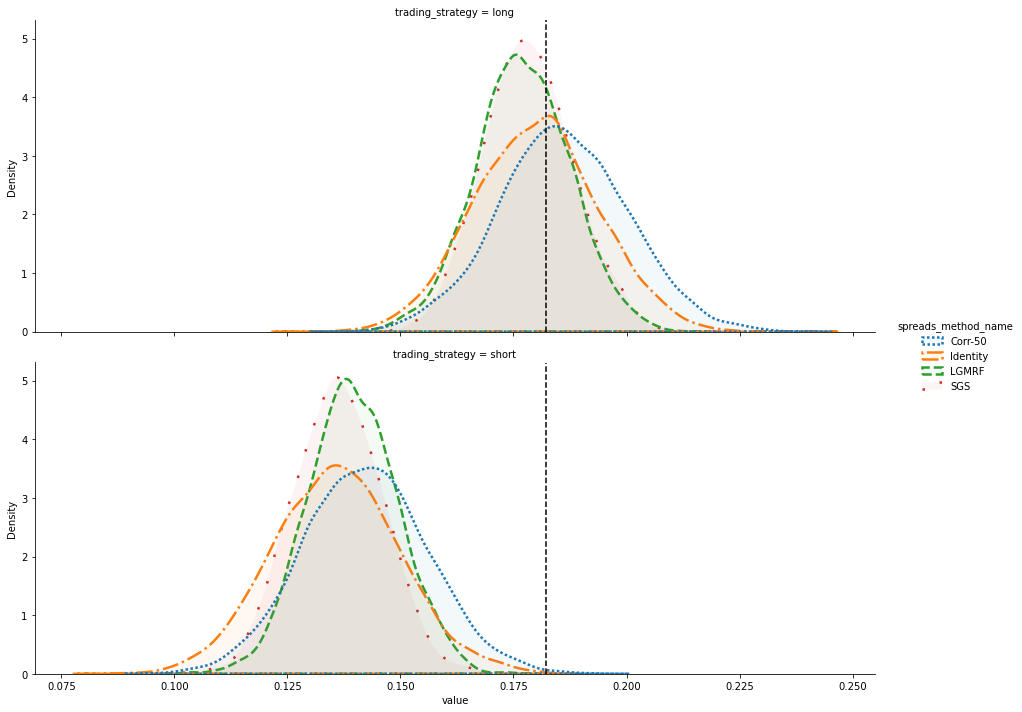

In [189]:
g = sns.displot(data=bs_expected_sharpe_spread_method, x='value', kind='kde', fill=True, alpha=.05,
            hue='spreads_method_name', row='trading_strategy', aspect=2.5, linewidth=2.5)
    
if flag_ls:
    for ax in g.axes.flat:
        for line, ls in zip(ax.collections, lss):
            line.set_linestyle(ls)
        ax.axvline(expected_sharpe_benchmark, ls='--', color='black')

    handles = g._legend.legendHandles[::-1]
    for handle, ls in zip(handles, lss):
        handle.set_ls(ls)
else:
    for ax in g.axes.flat:
        ax.axvline(expected_sharpe_benchmark, ls='--', color='black')
    
plt.show()

In [214]:
# print('Long Sharpe:')
# display(bs_expected_sharpe_spread_method[bs_expected_returns_spread_method['trading_strategy'] == 'long'].groupby('spreads_method_name')['value'].describe().iloc[:, 1:].style.highlight_max())
# 
# print('\nShort Sharpe:')
# display(bs_expected_sharpe_spread_method[bs_expected_returns_spread_method['trading_strategy'] == 'short'].groupby('spreads_method_name')['value'].describe().iloc[:, 1:].style.highlight_min())

print('Long Sharpe:')
display(bs_expected_sharpe_spread_method[bs_expected_returns_spread_method['trading_strategy'] == 'long'].groupby('spreads_method_name')['value'].describe().iloc[:, 1:])

print('\nShort Sharpe:')
display(bs_expected_sharpe_spread_method[bs_expected_returns_spread_method['trading_strategy'] == 'short'].groupby('spreads_method_name')['value'].describe().iloc[:, 1:])

Long Sharpe:


,mean,std,min,25%,50%,75%,max
spreads_method_name,,,,,,,
Corr-50,0.185968,0.014237,0.137567,0.176406,0.185698,0.195310,0.237485
Identity,0.180005,0.013639,0.128915,0.170605,0.180195,0.188970,0.239123
LGMRF,0.177093,0.010480,0.141174,0.170175,0.176865,0.184097,0.212609
SGS,0.178228,0.009874,0.140150,0.171443,0.178029,0.184833,0.217374



Short Sharpe:


,mean,std,min,25%,50%,75%,max
spreads_method_name,,,,,,,
Corr-50,0.142237,0.013804,0.096529,0.132774,0.142278,0.151345,0.193089
Identity,0.135866,0.014023,0.085200,0.126212,0.135843,0.145048,0.181866
LGMRF,0.139455,0.009929,0.103091,0.132823,0.139251,0.146077,0.175250
SGS,0.136185,0.009804,0.101980,0.129464,0.136134,0.142811,0.171325


Come si può vedere i risultati sono tutti bene o male sovrapponibili, anche Identity che non sfrutta un approccio basato sul pairs trading ma uno basato sul classico mean-reversion. 

Per quanto riguarda gli expected returns le distribuzioni sono tutte centrate all'incirca nello stesso punto tuttavia gli approcci basati sui grafi mostrano un'incertezza/deviazione standard considerevolmente minore.

Per quanto riguarda gli Sharpe ratio si può notare come, nel caso long, i maggiori ritorni non siano caratterizzati da una minore volatilità per cui nella maggior parte dei casi, ad eccezione di Corr-50, gli Sharpe ratio ottenuti sono peggiori del benchmark.

# Trading

Qui verifichiamo quali combinazioni di $w, q, \gamma$ generi i miglio risultati.

In [222]:
bs_expected_returns_trading_methods = bootstrap_dataset(
    melted_results_df_no_bench[(adjust_laplacian_false_filt &
                                corr_50_filt &
                                (melted_results_df_no_bench['variable'] == 'avg_month_returns') &
                                (melted_results_df_no_bench['trading_strategy'] != 'both') &
                                (melted_results_df_no_bench['residuals_method'] == 'residuals')
                               )], 
    id_vars=['trading_strategy', 'w', 'gamma-q'], 
    value_var='value', func=np.mean, n=5000)

bs_expected_sharpe_trading_methods = bootstrap_dataset(
    melted_results_df_no_bench[(adjust_laplacian_false_filt &
                                corr_50_filt &
                                (melted_results_df_no_bench['variable'] == 'avg_month_returns') &
                                (melted_results_df_no_bench['trading_strategy'] != 'both') &
                                (melted_results_df_no_bench['residuals_method'] == 'residuals')
                               )], 
    id_vars=['trading_strategy', 'w', 'gamma-q'], 
    value_var='value', func=sharpe, n=5000)

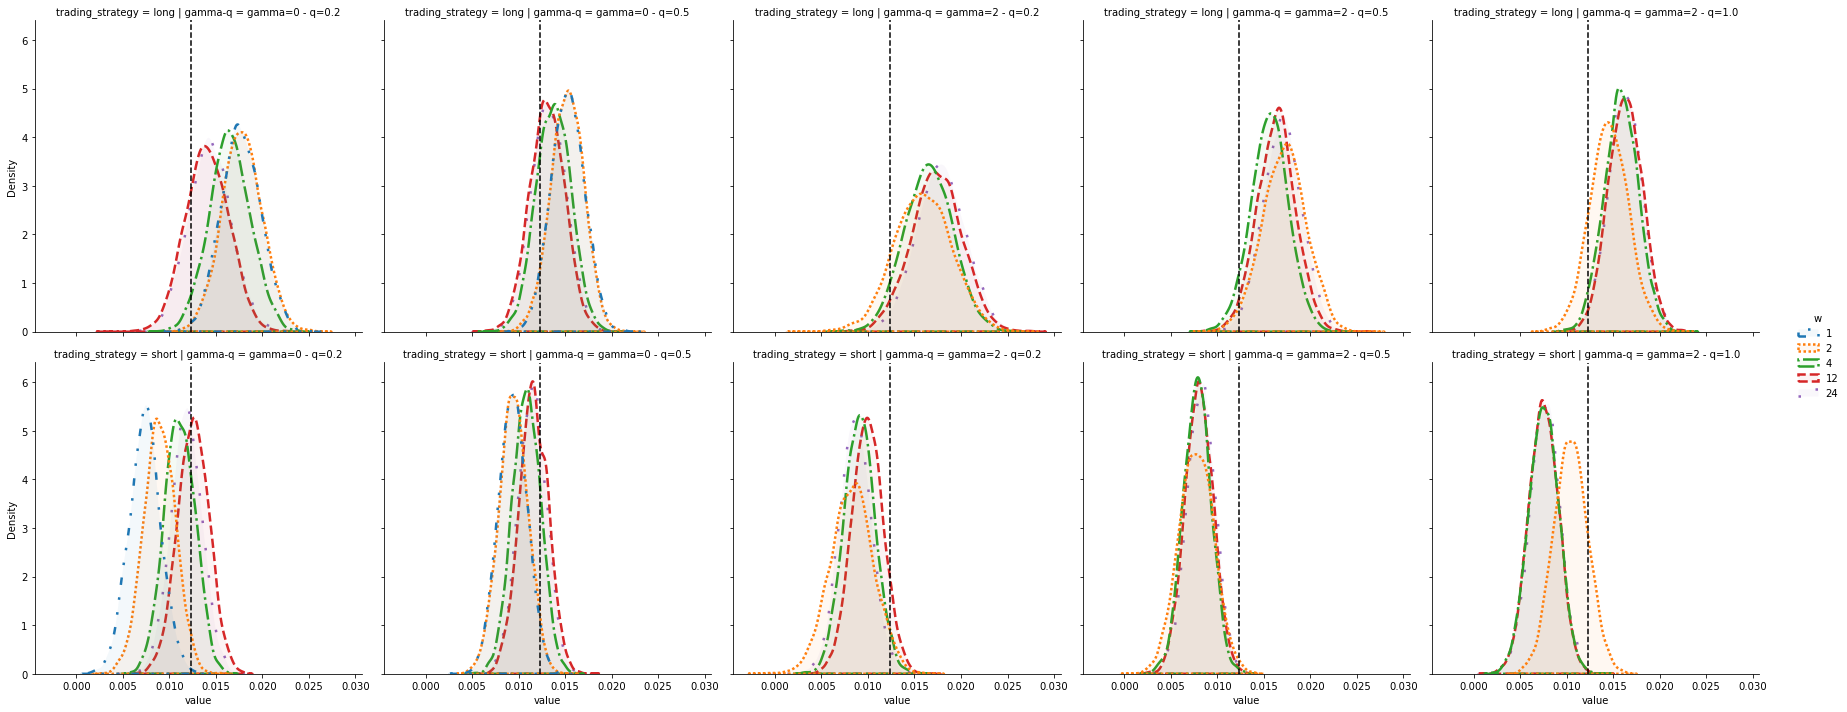

In [223]:
g = sns.displot(data=bs_expected_returns_trading_methods, x='value', kind='kde', fill=True, alpha=0.05,
                    col='gamma-q', row='trading_strategy', hue='w', palette='tab10', linewidth=2.5)

if flag_ls:
    for ax in g.axes.flat:
        for line, ls in zip(ax.collections, lss):
            line.set_linestyle(ls)
        ax.axvline(expected_return_benchmark, ls='--', color='black')

    handles = g._legend.legendHandles[::-1]
    for handle, ls in zip(handles, lss):
        handle.set_ls(ls)
else:
    for ax in g.axes.flat:
        ax.axvline(expected_return_benchmark, ls='--', color='black')
    
plt.show()

In [227]:
print('Long Returns:')
display(bs_expected_returns_trading_methods[bs_expected_returns_trading_methods['trading_strategy'] == 'long'].groupby(['w', 'gamma-q'])['value'].describe().drop(columns=['count']))
print('Short Returns:')
display(bs_expected_returns_trading_methods[bs_expected_returns_trading_methods['trading_strategy'] == 'short'].groupby(['w', 'gamma-q'])['value'].describe().drop(columns=['count']))

Long Returns:


mean       std       min       25%       50%  \
w  gamma-q                                                             
1  gamma=0 - q=0.2  0.017697  0.002116  0.010585  0.016262  0.017648   
   gamma=0 - q=0.5  0.015283  0.001786  0.009353  0.014055  0.015285   
2  gamma=0 - q=0.2  0.017829  0.002165  0.010783  0.016370  0.017808   
   gamma=0 - q=0.5  0.015230  0.001786  0.008894  0.014041  0.015268   
   gamma=2 - q=0.2  0.015898  0.003083  0.002969  0.013822  0.015894   
   gamma=2 - q=0.5  0.017189  0.002357  0.008589  0.015603  0.017228   
   gamma=2 - q=1.0  0.014557  0.002087  0.007332  0.013159  0.014552   
4  gamma=0 - q=0.2  0.016519  0.002221  0.008819  0.015050  0.016464   
   gamma=0 - q=0.5  0.013746  0.001852  0.006624  0.012477  0.013776   
   gamma=2 - q=0.2  0.016529  0.002600  0.006701  0.014770  0.016540   
   gamma=2 - q=0.5  0.015628  0.002035  0.008086  0.014290  0.015656   
   gamma=2 - q=1.0  0.015851  0.001830  0.009452  0.014630  0.015852   
12 gamma=0 - q=0.2  0.014091  0.002333  0.003418  0.012517  0.014056   
   gamma=0 - q=0.5  0.013076  0.001870  0.006056  0.011812  0.013067   
   gamma=2 - q=0.2  0.017373  0.002716  0.007584  0.015592  0.017369   
   gamma=2 - q=0.5  0.016338  0.002061  0.008540  0.014976  0.016383   
   gamma=2 - q=1.0  0.016294  0.001830  0.009856  0.015048  0.016303   
24 gamma=0 - q=0.2  0.014324  0.002316  0.005598  0.012772  0.014325   
   gamma=0 - q=0.5  0.013220  0.001884  0.006000  0.011956  0.013196   
   gamma=2 - q=0.2  0.017839  0.002622  0.008667  0.016077  0.017838   
   gamma=2 - q=0.5  0.016980  0.002065  0.009397  0.015611  0.017000   
   gamma=2 - q=1.0  0.016268  0.001801  0.009424  0.015087  0.016267   

                         75%       max  
w  gamma-q                              
1  gamma=0 - q=0.2  0.019150  0.025382  
   gamma=0 - q=0.5  0.016508  0.022431  
2  gamma=0 - q=0.2  0.019256  0.026253  
   gamma=0 - q=0.5  0.016464  0.022559  
   gamma=2 - q=0.2  0.017985  0.026574  
   gamma=2 - q=0.5  0.018780  0.026661  
   gamma=2 - q=1.0  0.015960  0.022431  
4  gamma=0 - q=0.2  0.017997  0.023819  
   gamma=0 - q=0.5  0.015034  0.020261  
   gamma=2 - q=0.2  0.018305  0.025385  
   gamma=2 - q=0.5  0.016952  0.023451  
   gamma=2 - q=1.0  0.017114  0.023118  
12 gamma=0 - q=0.2  0.015697  0.022789  
   gamma=0 - q=0.5  0.014348  0.019981  
   gamma=2 - q=0.2  0.019164  0.027639  
   gamma=2 - q=0.5  0.017666  0.025800  
   gamma=2 - q=1.0  0.017546  0.022644  
24 gamma=0 - q=0.2  0.015860  0.023031  
   gamma=0 - q=0.5  0.014531  0.019763  
   gamma=2 - q=0.2  0.019601  0.026943  
   gamma=2 - q=0.5  0.018348  0.024276  
   gamma=2 - q=1.0  0.017470  0.023453

Short Returns:


mean       std       min       25%       50%  \
w  gamma-q                                                             
1  gamma=0 - q=0.2  0.007380  0.001718  0.001491  0.006278  0.007403   
   gamma=0 - q=0.5  0.009365  0.001546  0.003403  0.008322  0.009362   
2  gamma=0 - q=0.2  0.008957  0.001712  0.002570  0.007825  0.008943   
   gamma=0 - q=0.5  0.009438  0.001568  0.004157  0.008413  0.009438   
   gamma=2 - q=0.2  0.008277  0.002324 -0.001612  0.006737  0.008303   
   gamma=2 - q=0.5  0.007740  0.001884  0.000654  0.006456  0.007743   
   gamma=2 - q=1.0  0.010423  0.001838  0.004492  0.009189  0.010413   
4  gamma=0 - q=0.2  0.011123  0.001644  0.005659  0.009993  0.011104   
   gamma=0 - q=0.5  0.010843  0.001526  0.004997  0.009813  0.010848   
   gamma=2 - q=0.2  0.009092  0.001696  0.002835  0.007949  0.009090   
   gamma=2 - q=0.5  0.007830  0.001500  0.002477  0.006826  0.007847   
   gamma=2 - q=1.0  0.007520  0.001607  0.001878  0.006442  0.007523   
12 gamma=0 - q=0.2  0.012587  0.001702  0.006478  0.011437  0.012605   
   gamma=0 - q=0.5  0.011614  0.001536  0.005677  0.010580  0.011594   
   gamma=2 - q=0.2  0.009951  0.001705  0.003580  0.008792  0.009949   
   gamma=2 - q=0.5  0.008035  0.001519  0.002359  0.007006  0.008022   
   gamma=2 - q=1.0  0.007503  0.001592  0.001405  0.006426  0.007497   
24 gamma=0 - q=0.2  0.011856  0.001682  0.005389  0.010753  0.011862   
   gamma=0 - q=0.5  0.011459  0.001523  0.005646  0.010445  0.011488   
   gamma=2 - q=0.2  0.008637  0.001709  0.000649  0.007505  0.008653   
   gamma=2 - q=0.5  0.008255  0.001502  0.002868  0.007237  0.008289   
   gamma=2 - q=1.0  0.007641  0.001587  0.001358  0.006589  0.007666   

                         75%       max  
w  gamma-q                              
1  gamma=0 - q=0.2  0.008482  0.013835  
   gamma=0 - q=0.5  0.010401  0.014842  
2  gamma=0 - q=0.2  0.010131  0.015776  
   gamma=0 - q=0.5  0.010492  0.015681  
   gamma=2 - q=0.2  0.009806  0.016890  
   gamma=2 - q=0.5  0.009025  0.013944  
   gamma=2 - q=1.0  0.011635  0.016512  
4  gamma=0 - q=0.2  0.012263  0.016449  
   gamma=0 - q=0.5  0.011899  0.016165  
   gamma=2 - q=0.2  0.010210  0.015752  
   gamma=2 - q=0.5  0.008820  0.013271  
   gamma=2 - q=1.0  0.008604  0.014192  
12 gamma=0 - q=0.2  0.013745  0.018010  
   gamma=0 - q=0.5  0.012711  0.018079  
   gamma=2 - q=0.2  0.011085  0.016865  
   gamma=2 - q=0.5  0.009074  0.013361  
   gamma=2 - q=1.0  0.008597  0.014198  
24 gamma=0 - q=0.2  0.012973  0.017769  
   gamma=0 - q=0.5  0.012492  0.016960  
   gamma=2 - q=0.2  0.009792  0.015060  
   gamma=2 - q=0.5  0.009278  0.013354  
   gamma=2 - q=1.0  0.008699  0.014297

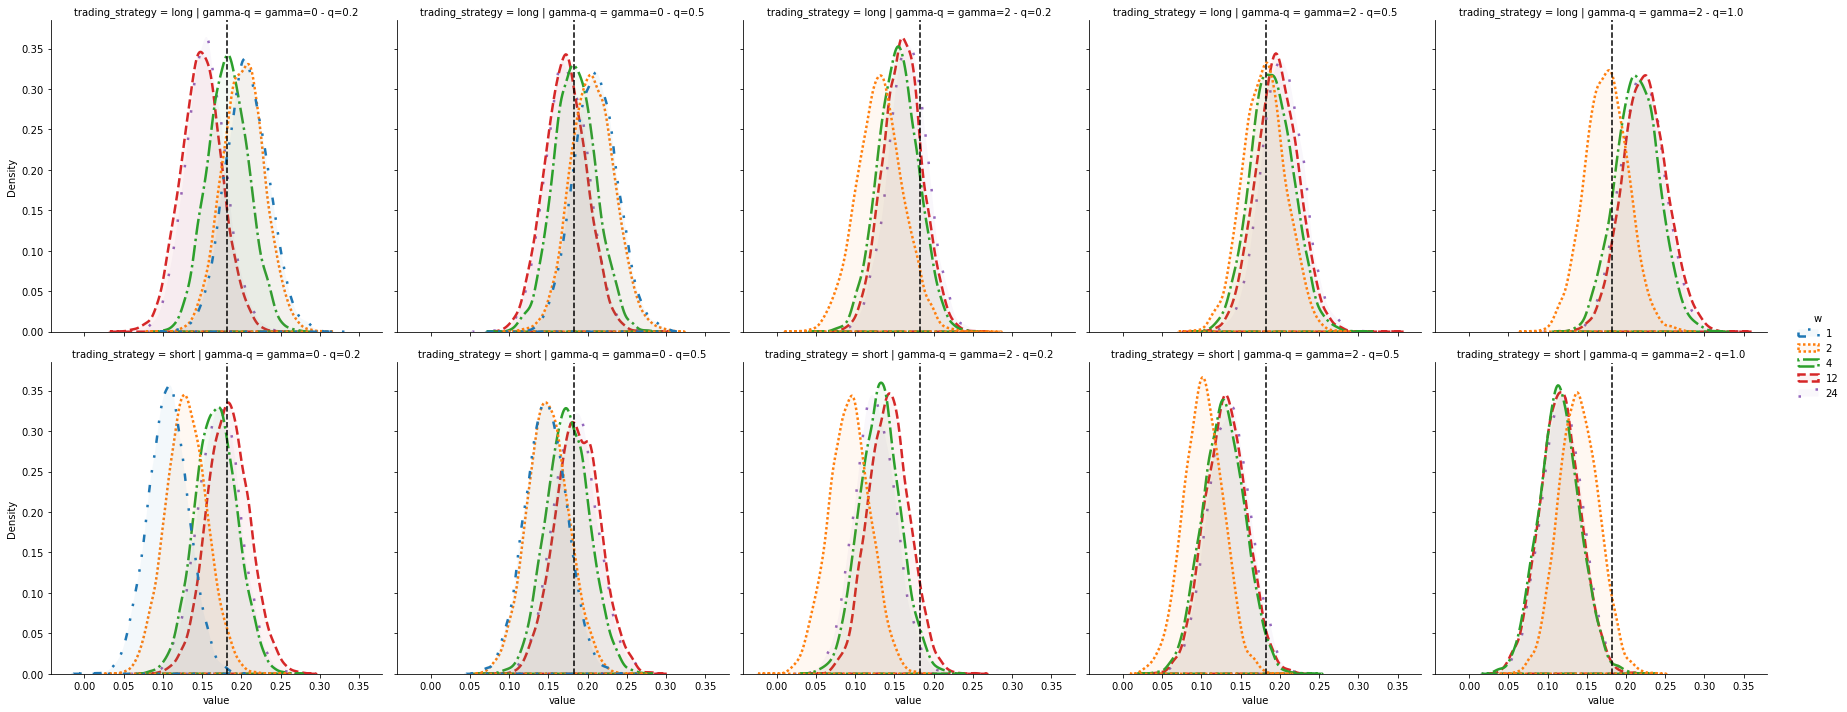

In [224]:
g = sns.displot(data=bs_expected_sharpe_trading_methods, x='value', kind='kde', fill=True, alpha=0.05,
                    col='gamma-q', row='trading_strategy', hue='w', linewidth=2.5, palette='tab10')
    
if flag_ls:
    for ax in g.axes.flat:
        for line, ls in zip(ax.collections, lss):
            line.set_linestyle(ls)
        ax.axvline(expected_sharpe_benchmark, ls='--', color='black')

    handles = g._legend.legendHandles[::-1]
    for handle, ls in zip(handles, lss):
        handle.set_ls(ls)
else:
    for ax in g.axes.flat:
        ax.axvline(expected_sharpe_benchmark, ls='--', color='black')
    
plt.show()

In [225]:
print('Long Sharp:')
display(bs_expected_sharpe_trading_methods[bs_expected_sharpe_trading_methods['trading_strategy'] == 'long'].groupby(['w', 'gamma-q'])['value'].describe().drop(columns=['count']))
print('Short Sharp:')
display(bs_expected_sharpe_trading_methods[bs_expected_sharpe_trading_methods['trading_strategy'] == 'short'].groupby(['w', 'gamma-q'])['value'].describe().drop(columns=['count']))

mean       std       min       25%       50%  \
w  gamma-q                                                             
1  gamma=0 - q=0.2  0.207378  0.027574  0.111092  0.189047  0.206567   
   gamma=0 - q=0.5  0.210266  0.027829  0.085833  0.191329  0.210095   
2  gamma=0 - q=0.2  0.202526  0.026500  0.092393  0.184662  0.202699   
   gamma=0 - q=0.5  0.206567  0.027875  0.107518  0.187468  0.205740   
   gamma=2 - q=0.2  0.131784  0.029548  0.025598  0.111885  0.131463   
   gamma=2 - q=0.5  0.180251  0.027163  0.085273  0.161531  0.180389   
   gamma=2 - q=1.0  0.175251  0.027269  0.078551  0.156472  0.175119   
4  gamma=0 - q=0.2  0.183091  0.026182  0.099686  0.165120  0.182941   
   gamma=0 - q=0.5  0.183955  0.026841  0.086023  0.165609  0.183456   
   gamma=2 - q=0.2  0.154599  0.025800  0.054519  0.136916  0.154524   
   gamma=2 - q=0.5  0.189949  0.027364  0.102745  0.171342  0.189323   
   gamma=2 - q=1.0  0.214199  0.027751  0.119974  0.195256  0.213907   
12 gamma=0 - q=0.2  0.149065  0.026414  0.046661  0.131535  0.149094   
   gamma=0 - q=0.5  0.172061  0.026712  0.087559  0.153822  0.171800   
   gamma=2 - q=0.2  0.160513  0.024874  0.064186  0.143821  0.160334   
   gamma=2 - q=0.5  0.196861  0.026844  0.090404  0.178700  0.196570   
   gamma=2 - q=1.0  0.223935  0.028261  0.123211  0.204711  0.223498   
24 gamma=0 - q=0.2  0.154538  0.025629  0.057996  0.137517  0.154253   
   gamma=0 - q=0.5  0.173557  0.026573  0.067125  0.155701  0.173340   
   gamma=2 - q=0.2  0.166920  0.025387  0.080732  0.150280  0.167028   
   gamma=2 - q=0.5  0.203323  0.026647  0.114211  0.184940  0.202750   
   gamma=2 - q=1.0  0.221222  0.027860  0.109405  0.201987  0.220818   

                         75%       max  
w  gamma-q                              
1  gamma=0 - q=0.2  0.226064  0.316595  
   gamma=0 - q=0.5  0.228747  0.304617  
2  gamma=0 - q=0.2  0.220299  0.303695  
   gamma=0 - q=0.5  0.225143  0.308437  
   gamma=2 - q=0.2  0.150844  0.270286  
   gamma=2 - q=0.5  0.198068  0.274700  
   gamma=2 - q=1.0  0.193858  0.273094  
4  gamma=0 - q=0.2  0.200938  0.276306  
   gamma=0 - q=0.5  0.201815  0.280206  
   gamma=2 - q=0.2  0.171902  0.242659  
   gamma=2 - q=0.5  0.208809  0.306228  
   gamma=2 - q=1.0  0.232833  0.317229  
12 gamma=0 - q=0.2  0.166239  0.246615  
   gamma=0 - q=0.5  0.189960  0.288303  
   gamma=2 - q=0.2  0.176825  0.256722  
   gamma=2 - q=0.5  0.215118  0.343710  
   gamma=2 - q=1.0  0.242809  0.345213  
24 gamma=0 - q=0.2  0.171383  0.252396  
   gamma=0 - q=0.5  0.192095  0.266994  
   gamma=2 - q=0.2  0.183898  0.258871  
   gamma=2 - q=0.5  0.220919  0.311947  
   gamma=2 - q=1.0  0.240332  0.326578

mean       std       min       25%       50%  \
w  gamma-q                                                             
1  gamma=0 - q=0.2  0.106610  0.025718 -0.000980  0.089285  0.106737   
   gamma=0 - q=0.5  0.147065  0.026635  0.059117  0.129211  0.146806   
2  gamma=0 - q=0.2  0.129950  0.026366  0.038894  0.111891  0.129404   
   gamma=0 - q=0.5  0.149738  0.026797  0.064197  0.131608  0.149064   
   gamma=2 - q=0.2  0.092531  0.026480 -0.009519  0.074354  0.092767   
   gamma=2 - q=0.5  0.102582  0.025269  0.022694  0.085349  0.102440   
   gamma=2 - q=1.0  0.139830  0.025648  0.052706  0.122082  0.139051   
4  gamma=0 - q=0.2  0.167646  0.026538  0.079594  0.149472  0.167719   
   gamma=0 - q=0.5  0.175042  0.027215  0.067153  0.156562  0.174736   
   gamma=2 - q=0.2  0.131612  0.025973  0.043149  0.114158  0.131509   
   gamma=2 - q=0.5  0.128295  0.026867  0.031784  0.109958  0.128004   
   gamma=2 - q=1.0  0.115083  0.026351  0.030210  0.097618  0.114605   
12 gamma=0 - q=0.2  0.183320  0.027001  0.079870  0.164957  0.183046   
   gamma=0 - q=0.5  0.187313  0.027945  0.080589  0.168262  0.186760   
   gamma=2 - q=0.2  0.142776  0.026004  0.054730  0.124787  0.142670   
   gamma=2 - q=0.5  0.131271  0.026433  0.040213  0.112930  0.131115   
   gamma=2 - q=1.0  0.115948  0.025791  0.036877  0.098777  0.115809   
24 gamma=0 - q=0.2  0.171867  0.026814  0.073223  0.153540  0.172132   
   gamma=0 - q=0.5  0.184403  0.027861  0.092414  0.165501  0.184427   
   gamma=2 - q=0.2  0.125460  0.026283  0.036085  0.107909  0.124871   
   gamma=2 - q=0.5  0.135410  0.026848  0.046236  0.116931  0.135448   
   gamma=2 - q=1.0  0.118493  0.025858  0.029957  0.100922  0.118454   

                         75%       max  
w  gamma-q                              
1  gamma=0 - q=0.2  0.123855  0.199112  
   gamma=0 - q=0.5  0.165037  0.247837  
2  gamma=0 - q=0.2  0.147617  0.247471  
   gamma=0 - q=0.5  0.167382  0.260391  
   gamma=2 - q=0.2  0.110266  0.180136  
   gamma=2 - q=0.5  0.119552  0.201859  
   gamma=2 - q=1.0  0.157421  0.237281  
4  gamma=0 - q=0.2  0.185778  0.264198  
   gamma=0 - q=0.5  0.193619  0.270994  
   gamma=2 - q=0.2  0.148557  0.225235  
   gamma=2 - q=0.5  0.146517  0.239478  
   gamma=2 - q=1.0  0.132195  0.226532  
12 gamma=0 - q=0.2  0.201348  0.280727  
   gamma=0 - q=0.5  0.206518  0.286172  
   gamma=2 - q=0.2  0.159761  0.254232  
   gamma=2 - q=0.5  0.149125  0.223313  
   gamma=2 - q=1.0  0.133380  0.213577  
24 gamma=0 - q=0.2  0.189894  0.266657  
   gamma=0 - q=0.5  0.202716  0.275136  
   gamma=2 - q=0.2  0.143192  0.222159  
   gamma=2 - q=0.5  0.153660  0.233545  
   gamma=2 - q=1.0  0.136090  0.211492

Innanzitutto va notato come spesso non vi sia moltissima differenza tra le varie combinazioni.

Per quanto riguarda la strategia long: le combinazioni che massimizzano gli expected returns fanno uso principalmente di finestre corte (w=1, 2) e un limitato uso di gamma (gamma=0, q=0.2); d'altro canto le combinazioni che massimizzano gli Sharpe ratios usono finestre più lunghe (w=12, 24) e approcci basati su gamma (gamma=2, q=1.0).

Per quanto riguarda la strategia short: le combinazioni migliosi sono all'incirca le stesse, finestre corte con approcci basati sui quantili (w=1, gamma=0, q=0.2) oppure finestre lunghe con approcci basati su gamma (w=12, gamma=2, q=1.0)
